# ThinkBrake: Oracle Analysis

## Import and Configs

In [1]:
import os
import sys

os.environ["THINKBRAKE_ROOT"] = "/home/work/ThinkBrake"
sys.path.insert(0, "/home/work/ThinkBrake")

In [2]:
import re
import json
import pandas as pd
from math_verify import parse, verify

from thinkbrake.func.constants import (
    RESULT_DIR,
    ORACLE_PREFIX,
    ROLLOUT_PREFIX,
)
from thinkbrake.func.utils import get_parent_category

print(f"Result directory: {RESULT_DIR}")

Result directory: /home/work/ThinkBrake/outputs


## Load Data

In [3]:
TARGET_MODELS = ["Qwen/Qwen3-4B-Thinking-2507"]
TARGET_CATEGORIES = ["gsm8k", "math500", "aime2024", "aime2025"]

TARGET_MODELS = [s.replace("/", "_") for s in TARGET_MODELS]

In [4]:
def evaluate_oracle_file(file_path: str, sub_category: str = None) -> dict:
    results_by_problem = {}
    parent_category = get_parent_category(sub_category) if sub_category else None
    is_multiple_choice = parent_category == "general"

    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            item = json.loads(line.strip())
            problem_id = item["id"]
            sentence_idx = item.get("sentence_idx", 0)

            if sentence_idx == 0:
                continue

            if problem_id not in results_by_problem:
                results_by_problem[problem_id] = {
                    "ground_truth": item["answer"],
                    "oracle_hit": False,
                    "correct_sentence_indices": [],
                    "total_sentences": 0,
                    "first_correct_idx": None,
                    "token_lengths": [],
                }

            results_by_problem[problem_id]["total_sentences"] += 1
            response = item.get("response", "")
            token_length = item.get("token_length", len(response.split()))
            results_by_problem[problem_id]["token_lengths"].append(token_length)

            try:
                if is_multiple_choice:
                    ground_truth = item["answer"]
                    predicted = item.get("response", "")
                    patterns = [
                        r'["\*]*answer["\*]*\s*[:=]\s*["\']?([A-Da-d])["\']?',
                        r"(?:the\s+)?answer\s+is[:\s]*([A-Da-d])\b",
                        r"\b([A-Da-d])\s*$",
                    ]
                    predicted_answer = ""
                    for pattern in patterns:
                        matches = re.findall(pattern, predicted, re.IGNORECASE)
                        if matches:
                            predicted_answer = matches[-1].upper()
                            break
                    is_correct = (
                        ground_truth.upper().strip() == predicted_answer.upper().strip()
                    )
                else:
                    ground_truth = parse(f"${item['answer']}$")
                    predicted = parse(response)
                    is_correct = verify(ground_truth, predicted)

                if is_correct:
                    results_by_problem[problem_id]["oracle_hit"] = True
                    results_by_problem[problem_id]["correct_sentence_indices"].append(
                        sentence_idx
                    )
                    if results_by_problem[problem_id]["first_correct_idx"] is None:
                        results_by_problem[problem_id][
                            "first_correct_idx"
                        ] = sentence_idx

            except Exception:
                pass

    return results_by_problem


def aggregate_oracle_results(results_by_problem: dict) -> dict:
    total = len(results_by_problem)
    oracle_hits = sum(1 for r in results_by_problem.values() if r["oracle_hit"])

    first_correct_tokens = []
    for _, r in results_by_problem.items():
        if r["first_correct_idx"] is not None and r["first_correct_idx"] < len(
            r["token_lengths"]
        ):
            first_correct_tokens.append(r["token_lengths"][r["first_correct_idx"]])

    total_tokens = []
    for r in results_by_problem.values():
        if r["token_lengths"]:
            total_tokens.append(max(r["token_lengths"]))

    return {
        "total": total,
        "oracle_hits": oracle_hits,
        "oracle_accuracy": (oracle_hits / total * 100) if total > 0 else 0.0,
        "avg_first_correct_tokens": (
            sum(first_correct_tokens) / len(first_correct_tokens)
            if first_correct_tokens
            else 0.0
        ),
        "avg_total_tokens": (
            sum(total_tokens) / len(total_tokens) if total_tokens else 0.0
        ),
    }

In [5]:
def collect_oracle_results(
    target_models: list = None, target_categories: list = None
) -> dict:
    all_results = {}

    for model_dir in RESULT_DIR.iterdir():
        if not model_dir.is_dir() or model_dir.name.startswith("leaderboard"):
            continue

        model_name = model_dir.name

        if target_models is not None and model_name not in target_models:
            continue

        all_results[model_name] = {}

        for parent_cat_dir in model_dir.iterdir():
            if not parent_cat_dir.is_dir():
                continue

            oracle_dir = parent_cat_dir / ORACLE_PREFIX
            if not oracle_dir.exists():
                continue

            for result_file in oracle_dir.glob("*_result.jsonl"):
                sub_category = result_file.stem.replace("_result", "")

                if (
                    target_categories is not None
                    and sub_category not in target_categories
                ):
                    continue

                try:
                    results_by_problem = evaluate_oracle_file(
                        str(result_file), sub_category
                    )
                    aggregated = aggregate_oracle_results(results_by_problem)
                    all_results[model_name][sub_category] = {
                        "detailed": results_by_problem,
                        "summary": aggregated,
                    }
                    print(f"Processed: {model_name} / {sub_category}")
                except Exception as e:
                    print(f"Error processing {model_name}: {e}")

    return all_results

In [6]:
oracle_results = collect_oracle_results(
    target_models=TARGET_MODELS, target_categories=TARGET_CATEGORIES
)

Processed: Qwen_Qwen3-4B-Thinking-2507 / aime2025
Processed: Qwen_Qwen3-4B-Thinking-2507 / aime2024
Processed: Qwen_Qwen3-4B-Thinking-2507 / gsm8k
Processed: Qwen_Qwen3-4B-Thinking-2507 / math500


In [7]:
def evaluate_rollout_file(file_path: str, sub_category: str = None) -> dict:
    parent_category = get_parent_category(sub_category) if sub_category else None
    is_multiple_choice = parent_category == "general"

    correct_count = 0
    total_count = 0
    total_tokens = 0

    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            item = json.loads(line.strip())

            try:
                if is_multiple_choice:
                    ground_truth = item["answer"]
                    predicted = item.get("response", "")
                    patterns = [
                        r'["\*]*answer["\*]*\s*[:=]\s*["\']?([A-Da-d])["\']?',
                        r"(?:the\s+)?answer\s+is[:\s]*([A-Da-d])\b",
                        r"\b([A-Da-d])\s*$",
                    ]
                    predicted_answer = ""
                    for pattern in patterns:
                        matches = re.findall(pattern, predicted, re.IGNORECASE)
                        if matches:
                            predicted_answer = matches[-1].upper()
                            break
                    is_correct = (
                        ground_truth.upper().strip() == predicted_answer.upper().strip()
                    )
                else:
                    ground_truth = parse(f"${item['answer']}$")
                    predicted = parse(item.get("response", ""))
                    is_correct = verify(ground_truth, predicted)

                if is_correct:
                    correct_count += 1

            except Exception:
                pass

            total_count += 1
            total_tokens += item.get("token_length", 0)

    accuracy = (correct_count / total_count * 100) if total_count > 0 else 0.0
    avg_token_length = (total_tokens / total_count) if total_count > 0 else 0.0

    return {
        "total": total_count,
        "correct": correct_count,
        "accuracy": accuracy,
        "avg_token_length": avg_token_length,
    }


def collect_rollout_results(
    target_models: list = None, target_categories: list = None
) -> dict:
    all_results = {}

    for model_dir in RESULT_DIR.iterdir():
        if not model_dir.is_dir() or model_dir.name.startswith("leaderboard"):
            continue

        model_name = model_dir.name

        if target_models is not None and model_name not in target_models:
            continue

        all_results[model_name] = {}

        for parent_cat_dir in model_dir.iterdir():
            if not parent_cat_dir.is_dir():
                continue

            rollout_dir = parent_cat_dir / ROLLOUT_PREFIX
            if not rollout_dir.exists():
                continue

            for result_file in rollout_dir.glob("*_result.jsonl"):
                sub_category = result_file.stem.replace("_result", "")

                if (
                    target_categories is not None
                    and sub_category not in target_categories
                ):
                    continue

                try:
                    result = evaluate_rollout_file(str(result_file), sub_category)
                    all_results[model_name][sub_category] = result
                    print(f"Processed rollout: {model_name} / {sub_category}")
                except Exception as e:
                    print(f"Error processing rollout {model_name}/{sub_category}: {e}")

    return all_results

In [8]:
rollout_data = collect_rollout_results(
    target_models=TARGET_MODELS, target_categories=TARGET_CATEGORIES
)

Processed rollout: Qwen_Qwen3-4B-Thinking-2507 / aime2024
Processed rollout: Qwen_Qwen3-4B-Thinking-2507 / aime2025
Processed rollout: Qwen_Qwen3-4B-Thinking-2507 / gsm8k
Processed rollout: Qwen_Qwen3-4B-Thinking-2507 / math500


## Evaluate and Comparison

In [9]:
comparison_data = []

for model_name, categories in oracle_results.items():
    for category, result in categories.items():
        summary = result["summary"]
        rollout_cat_data = rollout_data.get(model_name, {}).get(category, None)

        comparison_data.append(
            {
                "Model": model_name,
                "Category": category,
                "Oracle Accuracy (%)": round(summary["oracle_accuracy"], 2),
                "Oracle Hits": summary["oracle_hits"],
                "Total Problems": summary["total"],
                "Rollout Accuracy (%)": (
                    round(rollout_cat_data["accuracy"], 2) if rollout_cat_data else None
                ),
                "Rollout Correct": (
                    rollout_cat_data["correct"] if rollout_cat_data else None
                ),
                "Avg First Correct Tokens": round(
                    summary["avg_first_correct_tokens"], 0
                ),
                "Rollout Avg Tokens": (
                    round(rollout_cat_data["avg_token_length"], 0)
                    if rollout_cat_data
                    else None
                ),
            }
        )

df_comparison = pd.DataFrame(comparison_data)
df_comparison

,Model,Category,Oracle Accuracy (%),Oracle Hits,Total Problems,Rollout Accuracy (%),Rollout Correct,Avg First Correct Tokens,Rollout Avg Tokens
0,Qwen_Qwen3-4B-Thinking-2507,aime2025,93.33,28,30,40.00,12,11619.0,17369.0
1,Qwen_Qwen3-4B-Thinking-2507,aime2024,86.67,26,30,53.33,16,11270.0,16070.0
2,Qwen_Qwen3-4B-Thinking-2507,gsm8k,97.80,1290,1319,95.45,1259,487.0,1565.0
3,Qwen_Qwen3-4B-Thinking-2507,math500,99.80,499,500,95.40,477,2541.0,6405.0


## Save

In [10]:
def save_oracle_leaderboard(oracle_results: dict, rollout_data: dict):
    leaderboard_data = []

    for model_name, categories in oracle_results.items():
        if not categories:
            continue
        for category, result in categories.items():
            summary = result["summary"]
            rollout_cat_data = rollout_data.get(model_name, {}).get(category, None)

            leaderboard_data.append(
                {
                    "Model": model_name,
                    "Category": category,
                    "Oracle Accuracy": round(summary["oracle_accuracy"], 2),
                    "Rollout Accuracy": (
                        round(rollout_cat_data["accuracy"], 2)
                        if rollout_cat_data
                        else None
                    ),
                    "Avg Oracle Tokens": round(summary["avg_first_correct_tokens"], 2),
                    "Rollout Avg Tokens": (
                        round(rollout_cat_data["avg_token_length"], 2)
                        if rollout_cat_data
                        else None
                    ),
                }
            )

    df_leaderboard = pd.DataFrame(leaderboard_data)
    output_file = RESULT_DIR / f"leaderboard_{ORACLE_PREFIX}.csv"
    df_leaderboard.to_csv(output_file, index=False, encoding="utf-8")

    print(f"Saved oracle leaderboard to: {output_file}")
    return df_leaderboard

In [11]:
oracle_leaderboard = save_oracle_leaderboard(oracle_results, rollout_data)
oracle_leaderboard

Saved oracle leaderboard to: /home/work/ThinkBrake/outputs/leaderboard_oracle.csv


,Model,Category,Oracle Accuracy,Rollout Accuracy,Avg Oracle Tokens,Rollout Avg Tokens
0,Qwen_Qwen3-4B-Thinking-2507,aime2025,93.33,40.00,11619.00,17369.27
1,Qwen_Qwen3-4B-Thinking-2507,aime2024,86.67,53.33,11269.50,16069.73
2,Qwen_Qwen3-4B-Thinking-2507,gsm8k,97.80,95.45,487.44,1565.29
3,Qwen_Qwen3-4B-Thinking-2507,math500,99.80,95.40,2541.44,6405.14


## Plots

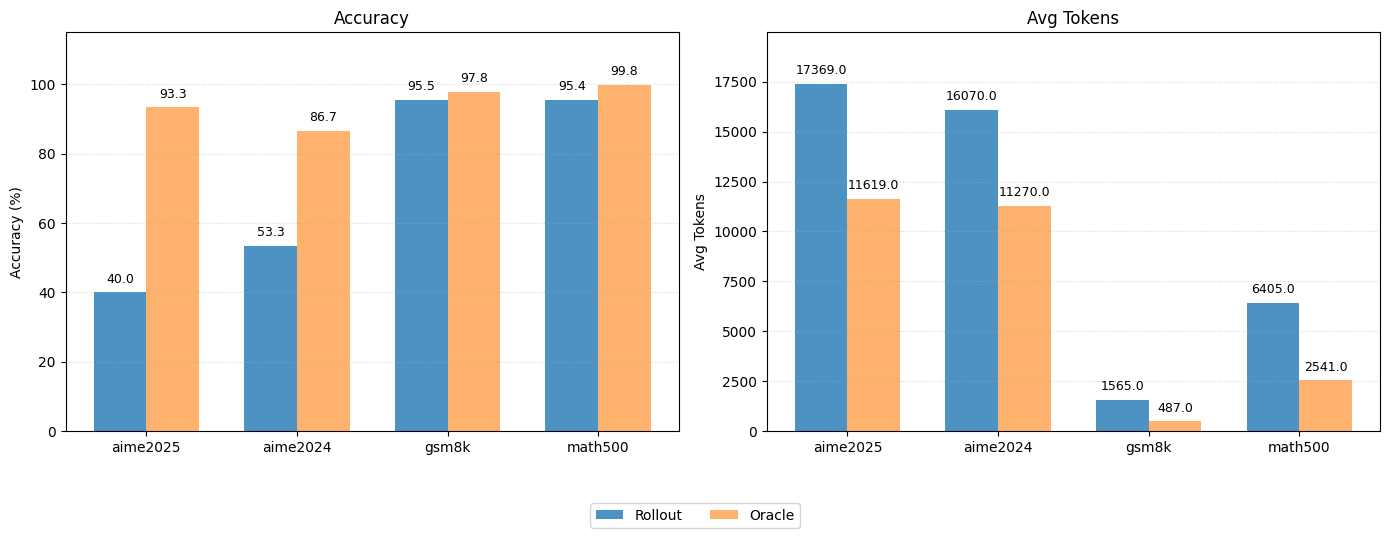

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plot_df = df_comparison.copy()

categories = plot_df["Category"].unique().tolist()
models = plot_df["Model"].unique().tolist()
n_cat = len(categories)

x = np.arange(n_cat)
bar_width = 0.35
max_acc = 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

# Assume only one model
model = models[0]
model_df = plot_df[plot_df["Model"] == model].set_index("Category")

# Subplot 1: Rollout vs Oracle Accuracy (Rollout left, Oracle right)
rollout_vals = [
    model_df.loc[c, "Rollout Accuracy (%)"] if c in model_df.index else 0
    for c in categories
]
oracle_vals = [
    model_df.loc[c, "Oracle Accuracy (%)"] if c in model_df.index else 0
    for c in categories
]
max_bar1 = max(rollout_vals + oracle_vals + [max_acc])
bars1 = axes[0].bar(
    x - bar_width / 2, rollout_vals, width=bar_width, label="Rollout", alpha=0.8
)
bars2 = axes[0].bar(
    x + bar_width / 2, oracle_vals, width=bar_width, label="Oracle", alpha=0.6
)
axes[0].set_xticks(x)
axes[0].set_xticklabels(categories)
axes[0].set_ylim(0, max_bar1 * 1.15)
axes[0].set_ylabel("Accuracy (%)")
axes[0].set_title(f"Accuracy")
axes[0].grid(axis="y", linestyle=":", alpha=0.5)
# Add value labels
for bar in bars1:
    height = bar.get_height()
    axes[0].annotate(
        f"{height:.1f}",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 5),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=9,
    )
for bar in bars2:
    height = bar.get_height()
    axes[0].annotate(
        f"{height:.1f}",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 5),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=9,
    )

# Subplot 2: Rollout vs Oracle Avg Tokens (Rollout left, Oracle right)
rollout_tokens = [
    model_df.loc[c, "Rollout Avg Tokens"] if c in model_df.index else 0
    for c in categories
]
oracle_tokens = [
    model_df.loc[c, "Avg First Correct Tokens"] if c in model_df.index else 0
    for c in categories
]
max_tokens = max(max(oracle_tokens), max(rollout_tokens), 100)
max_bar2 = max(rollout_tokens + oracle_tokens + [max_tokens])
bars3 = axes[1].bar(
    x - bar_width / 2, rollout_tokens, width=bar_width, label="Rollout", alpha=0.8
)
bars4 = axes[1].bar(
    x + bar_width / 2, oracle_tokens, width=bar_width, label="Oracle", alpha=0.6
)
axes[1].set_xticks(x)
axes[1].set_xticklabels(categories)
axes[1].set_ylim(0, max_bar2 * 1.15)
axes[1].set_ylabel("Avg Tokens")
axes[1].set_title(f"Avg Tokens")
axes[1].grid(axis="y", linestyle=":", alpha=0.5)
# Add value labels
for bar in bars3:
    height = bar.get_height()
    axes[1].annotate(
        f"{height:.1f}",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 5),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=9,
    )
for bar in bars4:
    height = bar.get_height()
    axes[1].annotate(
        f"{height:.1f}",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 5),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=9,
    )

# Move legend to the bottom center
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.08), ncol=2)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()